Why  do multiscale mixing scores seem to go down to -inf when from the paper it seems like they should be between 0 and 1?  Let's take a network with a very negative multiscale mixing score and figure out what's happening.

In [1]:
from datetime import datetime
from lassort.localassort import calculateRWRrange
import networkx as nx
import numpy as np
import pandas as pd

from networkx.generators.community import stochastic_block_model as sbm
from networkx.algorithms.community import modularity
from matplotlib import pyplot as plt
import scipy.sparse as sparse

In [14]:
N = 800
p = [[.1,.05], [.05, .1]]
s0 = 20

sizes = [s0, N - s0]
G = sbm(sizes, p)
A = nx.convert_matrix.to_scipy_sparse_matrix(G)
edgelist = nx.convert_matrix.to_pandas_edgelist(G).values
node_attr = np.hstack([np.zeros(sizes[0]), np.ones(sizes[1])])

missingValue = -1

In [21]:


# number of nodes
n = len(node_attr)
# number od nodes with complete attribute
ncomp = (node_attr != missingValue).sum()
# number of edges
m = len(edgelist)
degree = np.array(A.sum(1)).flatten()

D = sparse.diags(1./degree, 0, format='csc')
W = D @ A # every row sums  to 1

c = len(np.unique(node_attr))

In [22]:
# calculate node weights for how "complete" the
# metadata is around the node
Z = np.zeros(n)
Z[node_attr == missingValue] = 1.
Z = (W @ Z) / degree

# indicator array if node has attribute data (or missing)
hasAttribute = node_attr != missingValue


In [35]:
# calculate global expected values
values = np.ones(ncomp)
yi = (hasAttribute).nonzero()[0]
yj = node_attr[hasAttribute]
Y = sparse.coo_matrix((values, (yi, yj)), shape=(n, c)).tocsc()
eij_glob = np.array(Y.T @ (A @ Y).todense())
eij_glob /= np.sum(eij_glob)
ab_glob = np.sum(eij_glob.sum(1)*eij_glob.sum(0)) # this is ar^2 for undirected

In [36]:
ab_glob

0.9758403120359327

In [37]:
eij_glob

array([[5.49273021e-04, 1.16801292e-02],
       [1.16801292e-02, 9.76090468e-01]])

In [40]:
pr=np.arange(0., 1., 0.1)

assortM = np.empty((n, len(pr)))
assortT = np.empty(n)

In [48]:
WY = (W @ Y).tocsc()
WY.shape

(800, 2)

In [50]:
# WY[:,0] contains fraction of neighbors in grp 0
# likewise for 1
WY.todense()

matrix([[0.0625    , 0.9375    ],
        [0.02564103, 0.97435897],
        [0.        , 1.        ],
        ...,
        [0.03529412, 0.96470588],
        [0.        , 1.        ],
        [0.        , 1.        ]])

In [63]:
i = 0

# calculate for first node
pis, ti, it = calculateRWRrange(W, i, pr, n)
if len(pr) > 1:
    for ii, pri in enumerate(pr):
        pi = pis[:, ii]

        YPI = sparse.coo_matrix((pi[hasAttribute],
                                (node_attr[hasAttribute],
                                 np.arange(n)[hasAttribute])),
                                shape=(c, n)).tocsr()

        trace_e = (YPI.dot(WY).toarray()).trace()
        assortM[i, ii] = trace_e

In [65]:
assortM[0]

array([0.0625    , 0.1488576 , 0.23614159, 0.32441839, 0.41375813,
       0.50423497, 0.59592735, 0.68891832, 0.78329582, 0.87915296])

In [66]:
# this looks normal.  Let's run 'em all
for i in range(n):
    pis, ti, it = calculateRWRrange(W, i, pr, n)
    if len(pr) > 1:
        for ii, pri in enumerate(pr):
            pi = pis[:, ii]

            YPI = sparse.coo_matrix((pi[hasAttribute],
                                    (node_attr[hasAttribute],
                                     np.arange(n)[hasAttribute])),
                                    shape=(c, n)).tocsr()

            trace_e = (YPI.dot(WY).toarray()).trace()
            assortM[i, ii] = trace_e

    YPI = sparse.coo_matrix((ti[hasAttribute], (node_attr[hasAttribute],
                            np.arange(n)[hasAttribute])),
                            shape=(c, n)).tocsr()
    e_gh = (YPI @ WY).toarray()
    e_gh_sum = e_gh.sum()
    Z[i] = e_gh_sum
    e_gh /= e_gh_sum
    trace_e = e_gh.trace()
    assortT[i] = trace_e


In [68]:
assortM.min()

0.0

In [70]:
assortT.min()

0.48685940553871526

In [71]:
ab_glob

0.9758403120359327

In [72]:
assortT -= ab_glob
assortT.min()

-0.4889809064972174

In [73]:
np.divide(assortT, 1.-ab_glob, out=assortT, where=ab_glob != 0)
assortT.min()

-20.239537332786682

In [78]:
(assortT*(1-ab_glob)).min()

-0.4889809064972174

In [79]:
(assortT*(1-ab_glob)).max()

0.015322391735874241

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.48467761, -0.46467761, -0.44467761, -0.42467761, -0.40467761,
        -0.38467761, -0.36467761, -0.34467761, -0.32467761, -0.30467761,
        -0.28467761, -0.26467761, -0.24467761, -0.22467761, -0.20467761,
        -0.18467761, -0.16467761, -0.14467761, -0.12467761, -0.10467761,
        -0.08467761, -0.06467761, -0.04467761, -0.02467761, -0.00467761,
         0.01532239,  0.03532239,  0.05532239,  0.07532239,  0.09532239,
         0.11532239,  0.13532239,  0.15532239,  0.17532239,  0.19532239,
         0.21532239,  0.23532239,  0.25532239,  0.27532239,  0.29532239,
         0.31532239,  0.33532239,  0.35532239,  0.37532239,  0.39532239,
         0.41532239,  0.43532239,  0.45532239,  0.47532239,  0.49532239,
         0.51532239]),
 <BarContainer object

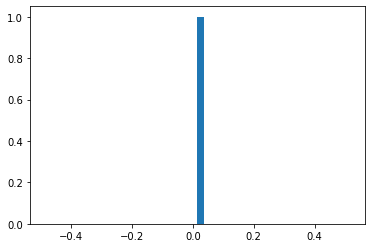

In [80]:
plt.hist((assortT*(1-ab_glob)).max(), bins=50)

Okay we found it!  It's this line where things get crazy  negative.  Why are we doing this?

This is the 1/Qmax in the paper.  As the largest group gets close to the whole thing, this number gets very tiny.

Okay, this makes sense but isn't directly useful.  If we don't divide everything by Qmax, the score distribution is shifted by a constant but it doesn't change the relative values of nodes.

WAIT or does it?!?!?!?!?

Within a fixed network with a fixed partition, Qmax is a constant.  The relative values from within different groups will not be effected.  However, with this modified planted partition model, Qmax does change with every shift in partition.

The question of why are smaller dorms less assortative wouldn't be helped here I think.  But at least I understand the bias of that experiment.

What happens if we use the SBM as a null model instead of the configuration model.  How many internal vs. external edges are we seeing in the neighborhood of this node relative to what we would expect to see if the whole network were evenly mixed?

Then we end up with scores that quantify deviation from the norm but don't give a flavor of whether the neighborhodd is assortative or dissassortative overall.

What do I want here?

A score that can be interpreted between networks?

In [44]:
a = np.array([[1,2], [2,1]])
b = np.array([-1, 1])

a @ b

array([ 1, -1])

In [47]:
b.dot(a)

array([ 1, -1])